# NMC/C Halfcell Data

In [1]:
import os
import sys
import math
sys.path.append(os.getcwd().partition('notebooks')[0])
from src.config_base import GeneralConfig

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator, FixedLocator
import matplotlib.patches as patches

In [3]:
from src.data.read_pickle import ReadPickle
from src.filtering.filter_methods import FilterMethods
from src.voltage_capacity_analysis.ica import ICA
from src.voltage_capacity_analysis.dva import DVA
from src.visualization.config_visualization import VisualizationConfig, instantiate_matplotlib_parameters, cm2inch
instantiate_matplotlib_parameters()
from src.visualization.colormaps import ColorMaps
from scipy import interpolate
from scipy.optimize import fsolve
from scipy.optimize import curve_fit

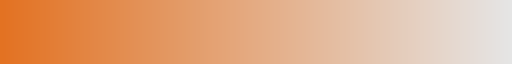

In [4]:
tum_orange_cmap = ColorMaps.orange_tum()
orange_colors = tum_orange_cmap(np.linspace(0,1, 10))
tum_orange_cmap

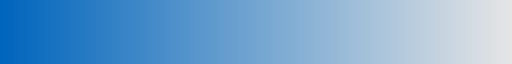

In [5]:
tum_blue_cmap = ColorMaps.blue_tum()
blue_colors = tum_blue_cmap(np.linspace(0,1, 10))
tum_blue_cmap

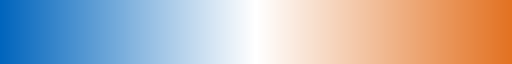

In [6]:
tum_cmap = ColorMaps.blue_orange_tum(grayscale=1)
colors = tum_cmap(np.linspace(0,1, 5))
tum_cmap

## Read Cell File

In [7]:
path2files = os.path.join(GeneralConfig.path2data.value,"VW","halfcell")

In [8]:
def filter_func_preprocess_U(signal):
    perc_filter = 0.1/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter * len(signal)))
    return filtered_signal

In [9]:
def filter_func_preprocess_Q(signal):
    perc_filter = 0.1/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [10]:
read_pickle = ReadPickle()
read_pickle.set_filter_U(filter_func_preprocess_U)
read_pickle.set_filter_Q(filter_func_preprocess_Q)

In [11]:
df_A =  read_pickle.read(os.path.join(path2files,"VW_LG_78Ah_NMC_20deg_C50_Anode.pkl"))
df_A = df_A[df_A["Q"]<=0.00805] # limit to above 0V 

In [12]:
df_C_ch =  read_pickle.read(os.path.join(path2files,"VW_LG_78Ah_NMC_20deg_C50_Cathode_ch.pkl"))
df_C_dch =  read_pickle.read(os.path.join(path2files,"VW_LG_78Ah_NMC_20deg_C50_Cathode_dch.pkl"))

In [13]:
def filter_func(signal):
    perc_filter =0.5 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    #filtered_signal_reverse = FilterMethods().savgol(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [14]:
path2files = os.path.join(GeneralConfig.path2data.value,"VW","cell")

In [15]:
df =  read_pickle.read(os.path.join(path2files,"VW_LG_78Ah_NMC_20deg_CC_C50.pkl"))

In [16]:
ica_extractor = ICA()
ica_extractor.set_filter(filter_func)
ica,volt =ica_extractor.get_ica(time=df["time_h"], capacity=df["Q"], voltage=df["U"],crop_volt_V=(2.6,4.2))

In [17]:
n=len(df_A)

In [18]:
df_A = df_A.sample(n=n).sort_values(by=['time_h'])
df_C_ch = df_C_ch.sample(n=n).sort_values(by=['time_h'])
df_C_dch = df_C_dch.sample(n=n).sort_values(by=['time_h'])
df = df.sample(n=n).sort_values(by=['time_h'])

### Cell DVA/ICA

In [19]:
def filter_func(signal):
    perc_filter = 0.5 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [20]:
def filter_func_cat(signal):
    perc_filter = 2.5 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [21]:
dva_extractor = DVA()
dva_extractor.set_filter(filter_func)
dva_A, cap_A =dva_extractor.get_dva(time=df["time_h"], capacity=df["Q"], voltage=df_A["U"],crop_cap_Ah=(0,100))
dva, cap =dva_extractor.get_dva(time=df["time_h"], capacity=df["Q"], voltage=df["U"],crop_cap_Ah=(0,100))
dva_extractor.set_filter(filter_func_cat)
dva_C_ch, cap_C_ch =dva_extractor.get_dva(time=df["time_h"], capacity=df["Q"], voltage=df_C_ch["U"],crop_cap_Ah=(0,100))
dva_C_dch, cap_C_dch =dva_extractor.get_dva(time=df["time_h"], capacity=df["Q"], voltage=df_C_dch["U"],crop_cap_Ah=(0,100))

(0.0, 0.05)

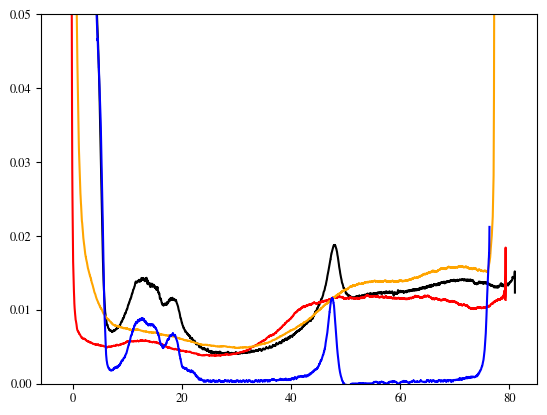

In [22]:
plt.plot(cap,dva,color = "black")
plt.plot(cap_C_ch-1.7,dva_C_ch-0.0007,color = "red")
plt.plot(cap_C_dch-1.7,np.flip(-1*(dva_C_dch-0.0007)),color = "orange")
plt.plot(cap_A*0.93+1,-1*dva_A,color = "blue")
plt.ylim([0,0.05])

This halfcell plot is schematic and should show the peaks as clear as possible
- the M and H2 Phase match best with the full cell level in the discharge curve, but the H1 peak is not visible
- the H1 peak is visible best in the charge curve

--> For the sake of clearness these two curves are merged to one, so the peaks are visible the best

stretch signals to match by hand

In [23]:
dva_A_trafo = -1*dva_A+0.0002
cap_A_trafo = cap_A*0.93+1
cap_A_trafo[cap_A_trafo>40]*=1.011
cap_A_trafo[cap_A_trafo>60]*=1.11

(0.0, 0.05)

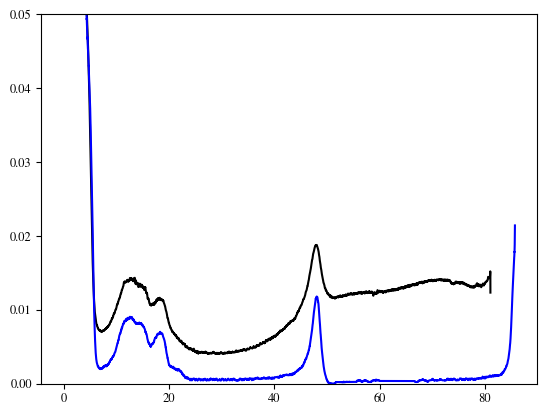

In [24]:
plt.plot(cap,dva,color = "black")
plt.plot(cap_A_trafo,dva_A_trafo,color = "blue")
plt.ylim([0,0.05])

In [25]:
dva_C_trafo_ch = dva_C_ch-0.0014
cap_C_trafo_ch = (cap_C_ch*1.2)-9
#cap_C_trafo[cap_C_trafo>20]*=1.1

In [26]:
dva_C_trafo_dch = -1*np.flip(dva_C_dch)
dva_C_trafo_dch = dva_C_trafo_dch-0.0010
cap_C_trafo_dch = (cap_C_dch-6.4)*1.1

(0.0, 0.05)

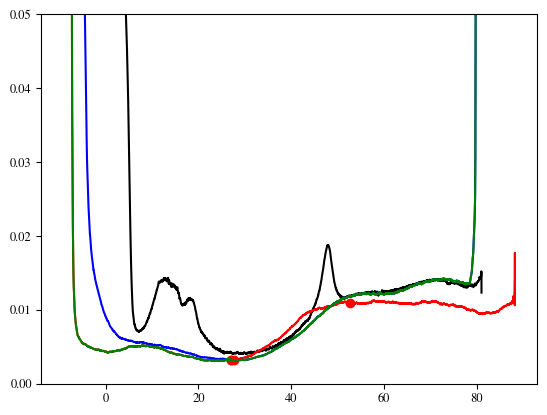

In [27]:
plt.plot(cap,dva,color = "black")
plt.plot(cap_C_trafo_ch,dva_C_trafo_ch,color = "red")
plt.plot(cap_C_trafo_dch,dva_C_trafo_dch,color = "blue")

idx = np.argwhere(np.diff(np.sign(dva_C_trafo_ch - dva_C_trafo_dch))).flatten()
plt.plot(cap_C_trafo_ch.values[idx], dva_C_trafo_ch[idx], 'ro')

idx_fit = idx[1]
cap_C_trafo = np.concatenate((cap_C_trafo_ch.values[0:idx_fit], cap_C_trafo_dch.values[idx_fit:]), axis=None)
dva_C_trafo = np.concatenate((dva_C_trafo_ch[0:idx_fit], dva_C_trafo_dch[idx_fit:]), axis=None)
plt.plot(cap_C_trafo,dva_C_trafo,color = "green")
plt.ylim([0,0.05])

In [28]:
df_C_ch_temp = df_C_ch[0:idx_fit]
df_C_dch["U"] = np.flip(df_C_dch["U"].values)
df_C_dch_temp = df_C_dch[idx_fit:]

In [29]:
df_C_ch_temp["U"]+= df_C_dch_temp["U"].min()-df_C_ch_temp["U"].max() # match voltage values

C:\Users\ga97req\AppData\Local\Temp\ipykernel_12976\3782774291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_C_ch_temp["U"]+= df_C_dch_temp["U"].min()-df_C_ch_temp["U"].max() # match voltage values


In [30]:
df_C = pd.concat([df_C_ch_temp, df_C_dch_temp], ignore_index=True)

## Plots C/50

In [31]:
def pOCV_plot(axes,df_FC,df_C,df_A):
    offset_interrup_y = 1
    axes.plot(df["Q"]+0.5,df["U"]-offset_interrup_y,color="black")
    axes.plot((df["Q"]-5)*1.08,df_C["U"]-offset_interrup_y,color=VisualizationConfig.TUMorange.value)
    
    cap_A = df["Q"].values*0.93+0.5
    cap_A[cap_A>60]*=1.07
    axes.plot(cap_A,df_A["U"],color=VisualizationConfig.TUMblau.value)
    
    axes.set_ylabel(r"Cell voltage in V",fontsize=9)
    axes.set_xlabel(r"Cell charge in Ah",fontsize=9)
    
    axes.set_ylim([0,4.5-offset_interrup_y])
    axes.set_xlim([-0.1,81])
    
    tick_positions = np.array([0,1,1.5,2.5,3.5])
    axes.set_yticks(tick_positions)
    axes.yaxis.set_minor_locator(FixedLocator([0.5,2,3]))
    
    axes.set_yticklabels([0,1,2.5,3.5,4.5])
    
    tick_positions = np.array([0,20,40,60,78])
    axes.set_xticks(tick_positions)
    axes.xaxis.set_minor_locator(FixedLocator([10,30,50,70]))
    
    axes.grid()
    axes.set_axisbelow(True)
    
    for k, spine in axes.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(1)
    axes.annotate(text="       ",
                          xy=(-2,1.28),
                          horizontalalignment="left",
                          verticalalignment="center",
                          fontsize=5,color="k",rotation=0,annotation_clip=False,
                    bbox=dict(boxstyle='square,pad=.0',fc='white', ec='white', alpha=1),zorder=2)

    axes.annotate(text="$||$",
                          xy=(0.44,1.325),
                          horizontalalignment="center",
                          verticalalignment="center",
                          fontsize=10,color="k",rotation=135,zorder=3)


    axes.annotate(text="       ",
                          xy=(80,1.28),
                          horizontalalignment="left",
                          verticalalignment="center",
                          fontsize=5,color="k",rotation=0,annotation_clip=False,
                    bbox=dict(boxstyle='square,pad=.0',fc='white', ec='white', alpha=1),zorder=2)

    axes.annotate(text="$||$",
                          xy=(81.5,1.325),
                          horizontalalignment="center",
                          verticalalignment="center",annotation_clip=False,
                          fontsize=10,color="k",rotation=135,zorder=3)
    return axes

In [32]:
def DVA_plot(axes,cap,dva,cap_C,dva_C,cap_A,dva_A):
    Q_nom = 78
    axes.plot(cap,dva*Q_nom,color="black")
    axes.plot(cap_C,dva_C*Q_nom,color=VisualizationConfig.TUMorange.value)
    axes.plot(cap_A,dva_A*Q_nom,color=VisualizationConfig.TUMblau.value)
    axes.set_ylabel(r"$Q_{cell}\ \cdot \ \left | \frac{dU_{cell}}{dQ_{cell}} \right |$ in V",fontsize=9)
    axes.set_xlabel(r"Cell charge in Ah",fontsize=9) 
    
    axes.set_ylim([0,2.5])
    tick_positions = np.array([0,0.5,1.0,1.5,2.0,2.5])
    axes.set_yticks(tick_positions)
    axes.set_xlim([-0.1,81])
    tick_positions = np.array([0,20,40,60,78])
    axes.set_xticks(tick_positions)
    axes.xaxis.set_minor_locator(FixedLocator([10,30,50,70]))
    axes.grid()
    axes.set_axisbelow(True)
    
    return axes

In [33]:
def ICA_plot(axes,volt,ica):

    axes.plot(volt,ica,color="black")
    
    mask = (volt>=3.58)&(volt<=3.7)
    axes.fill_between(x=volt[mask],y1 = ica[mask],y2=np.zeros(len(volt[mask])),interpolate=True,color=VisualizationConfig.TUMgrau20.value)

    axes.set_ylabel(r"$\frac{dQ_{cell}}{dU_{cell}}$ in $\frac{Ah}{V}$",fontsize=9)
    axes.set_xlabel(r"Cell voltage in V",fontsize=9) 
    
    axes.set_ylim([0,300])
    tick_positions = np.array([0,100,200,300])
    axes.set_yticks(tick_positions)
    axes.yaxis.set_minor_locator(FixedLocator([50,150,250]))
    axes.set_xlim([3.0,4.2])
    tick_positions = np.array([3.0,3.4,3.8,4.2])
    axes.set_xticks(tick_positions)
    axes.xaxis.set_minor_locator(FixedLocator([3.2,3.6,4.0]))
    
    axes.grid()
    axes.set_axisbelow(True)
    
    return axes

In [34]:
def add_FOI_DVA(axes):
    #anode
    axes.axvline(x=47.75, ymin=0.62, ymax=0.89,zorder=2, clip_on=False,color="k",linestyle="-",linewidth=1)
    axes.annotate(text='', xy=(0,2.1), xytext=(47.8,2.1), arrowprops=dict(arrowstyle='<|-|>', shrinkA=0, shrinkB=0,facecolor="k"))
    axes.annotate(text=r'$Q_{NE}$', xy=((47.8-0)/2+1,2.12),horizontalalignment="center",verticalalignment="bottom",fontsize=9)
    #Balancing
    axes.annotate(text='', xy=(81.1,2.1), xytext=(47.8,2.1), arrowprops=dict(arrowstyle='<|-|>', shrinkA=0, shrinkB=0,facecolor="k"))
    axes.annotate(text=r'$Q_B$', xy=((81-48.1)/2+48.1,2.12),horizontalalignment="center",verticalalignment="bottom",fontsize=9)
    #cathode
    axes.axvline(x=70, ymin=0.48, ymax=0.68,zorder=2, clip_on=False,color="k",linestyle="-",linewidth=1)
    axes.annotate(text='', xy=(81.1,1.6), xytext=(70,1.6), arrowprops=dict(arrowstyle='<|-|>', shrinkA=0, shrinkB=0,facecolor="k"))
    axes.annotate(text=r'$Q_{PE}$', xy=((81-70.4)/2+70.4-1,1.62),horizontalalignment="center",verticalalignment="bottom",fontsize=9)
    #stages
    axes.annotate(text='4L', xy=(12.0,1.16), xytext=(7,1.5),fontsize=9,verticalalignment="bottom",
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    axes.annotate(text='3L', xy=(15.6,1.1), xytext=(15,1.5),fontsize=9,verticalalignment="bottom",
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    axes.annotate(text='2L', xy=(19.55,0.93), xytext=(23,1.2),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    axes.annotate(text='stage 2', xy=(47,1.5), xytext=(30.5,1.7),fontsize=9,verticalalignment="bottom",
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
                     
    axes.annotate(text='H1', xy=(7.8,0.33), xytext=(13,0.05),fontsize=9,
                   arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    
    axes.annotate(text='M', xy=(55,0.8), xytext=(54,0.24),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
                      
    axes.annotate(text='H2', xy=(70,1.0), xytext=(72,0.55),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    
    return axes

In [35]:
def add_FOI_ICA(axes):
    axes.annotate(text='A', xy=(3.425,144), xytext=(3.3,120),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))   
    
    axes.annotate(text='B', xy=(3.66,250), xytext=(3.75,260),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    
    axes.annotate(text='C', xy=(3.77,45), xytext=(3.9,20),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    
    axes.annotate(text='D', xy=(4.05,85), xytext=(4.1,140),fontsize=9,
                      arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k", mutation_scale=20))
    
    #features
    # height
    axes.axhline(y=250, xmin=0.35, xmax=0.497,zorder=2, clip_on=False,color="k",linestyle="-",linewidth=1)
    axes.annotate(text='', xy=(3.44,147), xytext=(3.44,248), arrowprops=dict(arrowstyle='<|-|>', shrinkA=0, shrinkB=0,facecolor="k"))
    axes.annotate(text='$\\Delta h$', xy=(3.38,(248-147)/2+147),horizontalalignment="center",verticalalignment="center",fontsize=9,bbox=dict(boxstyle='square,pad=.1',fc='white', ec='white', alpha=0.75))
    # width 
    axes.annotate(text='', xy=(3.9,125), xytext=(3.7,125), arrowprops=dict(arrowstyle='<|-', shrinkA=0, shrinkB=0,facecolor="k"))
    axes.annotate(text='', xy=(3.49,125), xytext=(3.585,125), arrowprops=dict(arrowstyle='<|-', shrinkA=0, shrinkB=0,facecolor="k"))
    axes.annotate(text='', xy=(3.71,125), xytext=(3.585,125), arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0,facecolor="k",linestyle="--"))
    axes.annotate(text='$\\Delta w$', xy=(3.87,126),horizontalalignment="center",verticalalignment="bottom",fontsize=9)
    # integral
    axes.annotate(text='', xy=(3.57,20), xytext=(3.71,20), arrowprops=dict(arrowstyle='<|-|>', shrinkA=0, shrinkB=0,facecolor="k"))
    axes.annotate(text='$\\int$', xy=((3.71-3.57)/2+3.57+0.01,30),horizontalalignment="center",verticalalignment="bottom",fontsize=12)
    return axes

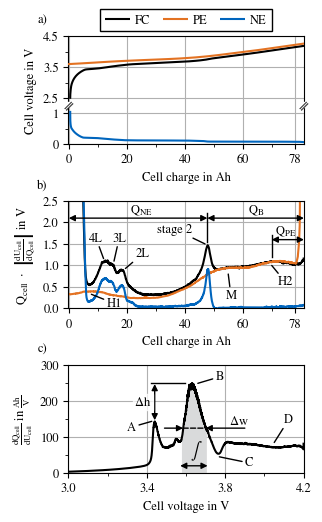

In [36]:
nrow = 3
fig, axes= plt.subplots(nrow,1,
                        figsize=(VisualizationConfig.columnwidth_in_in.value,
                                nrow*cm2inch(4.5)))
axes = axes.flatten()
axes[0] = pOCV_plot(axes[0],df,df_C,df_A)
axes[1] = DVA_plot(axes[1],cap,dva,cap_C_trafo,dva_C_trafo,cap_A_trafo,dva_A_trafo)
axes[2] = ICA_plot(axes[2],volt,ica)

axes[1] = add_FOI_DVA(axes[1])
axes[2] = add_FOI_ICA(axes[2])
# legend
handles, labels =axes[0].get_legend_handles_labels()  
line = plt.hlines(0,0,1,label='FC', color="black")
line_e = plt.hlines(0,0,1,label=' ', color="white")
line2 = plt.hlines(0,0,1,label='PE', color=VisualizationConfig.TUMorange.value)
line3 = plt.hlines(0,0,1,label='NE', color=VisualizationConfig.TUMblau.value)

# add manual symbols to auto legend
handles.extend([line, line2, line3])
axes[0].legend(handles=handles,loc="center",fontsize=9,ncols=3,handletextpad=0.4,
           framealpha =1 , fancybox=False,labelspacing=0,columnspacing=1,edgecolor="black",bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
# NR
axes[0].text(-0.11, 1.15, r'a)', horizontalalignment='center',
     verticalalignment='center', transform=axes[0].transAxes)
axes[1].text(-0.11, 1.15, r'b)', horizontalalignment='center',
     verticalalignment='center', transform=axes[1].transAxes)
axes[2].text(-0.11, 1.15, r'c)', horizontalalignment='center',
     verticalalignment='center', transform=axes[2].transAxes)
fig.savefig(os.path.join(GeneralConfig.path2figures.value,"00-POCV_DVA_ICA_VW_halfcells.pdf"))
fig.savefig(os.path.join(GeneralConfig.path2figures.value,"00-POCV_DVA_ICA_VW_halfcells.png"),dpi=300)